In [2]:
import pickle,sys,warnings
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pylab as plt
from scipy.optimize import curve_fit
def myprint(string,clear=False):
    if clear:
        sys.stdout.write("\033[F")
        sys.stdout.write("\033[K") 
    print(string)
warnings.filterwarnings("ignore")
def T(ba,ca):
    return( (1-ba**2)/(1-ca**2) )

def sersic(r, mueff, reff, n):
    return mueff + 2.5*(0.868*n-0.142)*((r/reff)**(1./n) - 1)
def func(x, a, c, d):
    return a*np.exp(-c*x)+d

def correlation(ell,sb):
    if not isinstance(ell,np.ndarray): ell = np.array(ell)
    if not isinstance(sb,np.ndarray): sb = np.array(sb)
    n = np.nansum( (ell-np.nanmean(ell)) * (sb-np.nanmean(sb)) )
    d1 = np.nansum( (ell-np.nanmean(ell))**2 )
    d2 = np.nansum( (sb-np.nanmean(sb))**2 )
    return n/np.sqrt(d1*d2)

def myround(x, base=5):
    return base * round(x/base)

def randomorientation(base=30):
    phi = np.degrees(np.random.uniform(0,np.pi*2))
    y = int(myround(phi,base=base))
    theta = np.degrees(np.arccos(np.random.uniform(-1,1)))
    x = int(myround(theta,base=base))
    if x>165:
        x = x%180
        y = (180-y)
        if y<0:
            y = y+360
    if y == 360:
        y = 0
    return(f'x{x:03d}y{y:03d}')


n_itr = int(1e5)
xbins = np.linspace(-1,1,500)
Xu = True
EnvSplit = True
Scatter = True
DimSplit = True
IndCor = True


#sims = ['h148','h229','h242','h329','cptmarvel','elektra','storm','rogue']

#Xu&Randall2020 (https://ui.adsabs.harvard.edu/abs/2020ApJ...900...69X/abstract)
LGall = [-0.287,0.058,'#7B0B01','All LG Dsphs']
LGbright = [-0.353,0.059,'#FFCC99','LG Dsphs\n'+r'$M/L<100M_\odot/L_\odot$']
LGdim = [0.509,0.309,'#339AFE','LG Dsphs\n'+r'$M/L>100M_\odot/L_\odot$']
FIRE = [-0.322,0.213,'#411B52','FIRE Simulations']
FIRE_Data = pd.read_csv('../../Data/BasicData/FIRE_Data.csv')
FIRE_x = FIRE_Data['X'].tolist()
FIRE_y = FIRE_Data['Y'].tolist()

SimInfo = pickle.load(open(f'../SimulationInfo.BW.pickle','rb'))
ProfData,ProjData,MorphData,ShapeData,MassData,nhalo = {},{},{},{},{},0
for sim in SimInfo:
    ProfData[sim]=pickle.load(open(f'../../Data/{sim}.BW.Profiles.pickle','rb'))
    ProjData[sim]=pickle.load(open(f'../../Data/{sim}.BW.ProjectedData.pickle','rb'))
    MorphData[sim]=pickle.load(open(f'../../Data/{sim}.BW.3DShapes.pickle','rb'))
    ShapeData[sim]=pickle.load(open(f'../../Data/{sim}.BW.ShapeData.pickle','rb'))
    MassData[sim]=pickle.load(open(f'../../Data/{sim}.BW.DynamicalMasses.pickle','rb'))
    nhalo+=len(ProfData[sim])
Masses = pickle.load(open('../../Data/BasicData/Marvel_DCJL.Masses.pickle','rb'))
#Lums = pickle.load(open('../Data/BasicData/Marvel_DCJL.Luminosity.pickle','rb'))

#Get central lum_den values from array fit
for sim in SimInfo:
    for halo in ProfData[sim]:
        for angle in ProfData[sim][halo]:
            mag0 = ProfData[sim][halo][angle]['mags,v'][0]
            area0 = ProfData[sim][halo][angle]['binarea'][0]
            ProfData[sim][halo][angle]['Sigma0'] = (10**(0.4*(4.8-mag0)))/area0
            
            Reff = ProfData[sim][halo]['x000y000']['Rhalf']
            indeff = np.argmin(np.abs(Reff - ProfData[sim][halo]['x000y000']['rbins']))
            lums = 10**(0.4*(4.8-ProfData[sim][halo][angle]['mags,v']))
            #ProfData[sim][halo][angle]['Lumeff'] = lums[:indeff+1].sum()
            lumeff = lums[:indeff+1].sum()
            ProfData[sim][halo][angle]['M/L'] = MassData[sim][halo]/lumeff

# for sim in ProfData:
#     for halo in ProfData[sim]:
#         print(f"{sim}-{halo}: {ProfData[sim][halo]['x000y000']['M/L']}")

Running Splits: 0.00%


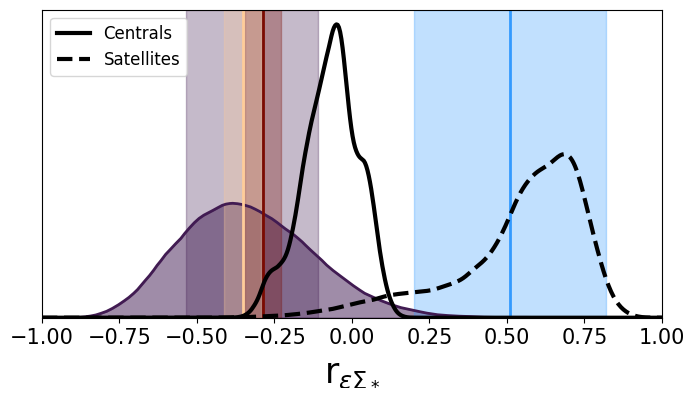

In [8]:
#Central, Satellite, and Splashback splitting
if EnvSplit:
    cens,sats,bsps = [],[],[]
    with open('../../Data/BasicData/HaloTypes.txt') as f:
        lines = f.readlines()

    for line in lines:
        l = line.split('\t')
        if l[0] in SimInfo:
            if l[-2]=='Central' and int(l[1]) in SimInfo[l[0]]['goodhalos']: cens.append((l[0],l[1]))
            elif l[-2]=='Satellite' and int(l[1]) in SimInfo[l[0]]['goodhalos']: sats.append((l[0],l[1]))
            elif l[-2]=='Backsplash' and int(l[1]) in SimInfo[l[0]]['goodhalos']: cens.append((l[0],l[1]))

    PlotDict = ShapeData
    r_dist_c,r_dist_s,r_dist_b,ind_r_c,ind_r_s,ind_r_b = [np.zeros(n_itr),np.zeros(n_itr),np.zeros(n_itr),
                                                          np.zeros(len(cens)),np.zeros(len(sats)),np.zeros(len(bsps))]
    print('Running Splits: 0.00%')
    for n in np.arange(n_itr):

        ell,sb,i = np.zeros(len(cens)),np.zeros(len(cens)),0  
        for halo in cens:
            angle = randomorientation()
            ell[i] = 1-PlotDict[halo[0]][halo[1]][angle]['b/a']
            sb[i] = ProfData[halo[0]][halo[1]][angle]['Sigma0']
            if n==n_itr-1:
                ell_ind,sb_ind,sbc_ind = [],[],[]
                for a in ProfData[halo[0]][halo[1]]:
                    ell_ind.append(1-PlotDict[halo[0]][halo[1]][a]['b/a'])
                    sb_ind.append(ProfData[halo[0]][halo[1]][a]['Sigma0'])
                ind_r_c[i] = correlation(ell_ind,sb_ind)
            i+=1
        r_dist_c[n] = correlation(ell,sb)
        
        ell,sb,i = np.zeros(len(sats)),np.zeros(len(sats)),0  
        for halo in sats:
            angle = randomorientation()
            ell[i] = 1-PlotDict[halo[0]][halo[1]][angle]['b/a']
            sb[i] = ProfData[halo[0]][halo[1]][angle]['Sigma0']
            if n==n_itr-1:
                ell_ind,sb_ind,sbc_ind = [],[],[]
                for a in ProfData[halo[0]][halo[1]]:
                    ell_ind.append(1-PlotDict[halo[0]][halo[1]][a]['b/a'])
                    sb_ind.append(ProfData[halo[0]][halo[1]][a]['Sigma0'])
                ind_r_s[i] = correlation(ell_ind,sb_ind)
            i+=1
        r_dist_s[n] = correlation(ell,sb)

        ell,sb,i = np.zeros(len(bsps)),np.zeros(len(bsps)),0  
        for halo in bsps:
            angle = randomorientation()
            ell[i] = 1-PlotDict[halo[0]][halo[1]][angle]['b/a']
            sb[i] = ProfData[halo[0]][halo[1]][angle]['Sigma0']
            if n==n_itr-1:
                ell_ind,sb_ind,sbc_ind = [],[],[]
                for a in ProfData[halo[0]][halo[1]]:
                    ell_ind.append(1-PlotDict[halo[0]][halo[1]][a]['b/a'])
                    sb_ind.append(ProfData[halo[0]][halo[1]][a]['Sigma0'])
                ind_r_b[i] = correlation(ell_ind,sb_ind)
            i+=1
        r_dist_b[n] = correlation(ell,sb)

        #myprint(f'Running Splits: {round((n+1)/n_itr*100,2)}%',clear=True)


    f,ax = plt.subplots(1,1,figsize=(8,4))
    ax.set_xlabel(r'r$_{\epsilon\Sigma_*}$',fontsize=25)
    ax.tick_params(which='both',labelsize=15)
    ax.set_xlim([-1,1])
    ax.set_yticks([])
    #ind_ax = ax.twiny()
    #ind_ax.set_xlim([-1,1])
    #ind_ax.set_xticks(np.ndarray.tolist(ind_r[np.isfinite(ind_r)]))
    #ind_ax.set_xticklabels([])
    #ind_ax.tick_params(axis='x',length=8,direction='in')

    ax.axvspan(FIRE[0]-FIRE[1],FIRE[0]+FIRE[1],color=FIRE[2],alpha=.3)
    ax.plot(FIRE_x,FIRE_y,color=FIRE[2],linewidth=2)#,label=FIRE[3])
    ax.fill_between(FIRE_x,[0]*len(FIRE_x),FIRE_y,color=FIRE[2],alpha=.5)
    for obs in [LGall,LGbright,LGdim]:
        ax.axvline(obs[0],color=obs[2],linewidth=2)#,label=obs[3])
        ax.axvspan(obs[0]-obs[1],obs[0]+obs[1],color=obs[2],alpha=.3)

    density = stats.gaussian_kde(r_dist_c)
    ax.plot(xbins,density(xbins),c='k',linewidth=3,label='Centrals')
    density = stats.gaussian_kde(r_dist_s)
    ax.plot(xbins,density(xbins),c='k',linewidth=3,linestyle='--',label='Satellites')
    # density = stats.gaussian_kde(r_dist_b)
    # ax.plot(xbins,density(xbins),c='k',linewidth=3,linestyle=':',label='Backsplash')

    ax.set_ylim(bottom=0)
    ax.legend(loc='upper left',prop={'size':12})
    #plt.show()
    f.savefig('../../Figures/CorrelationTesting/Correlation.Subpopulations.png',bbox_inches='tight',pad_inches=.1)
    #plt.close()

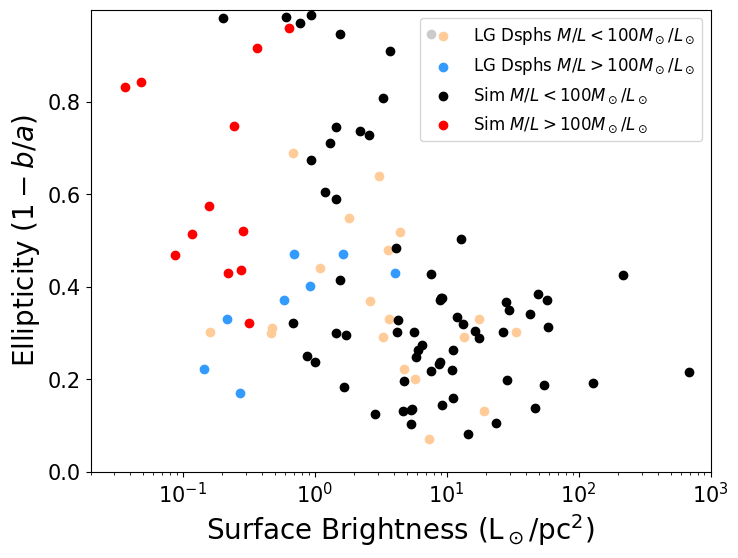

In [10]:
#Ell vs SB Scatter Plots
if Scatter:

    #RGBs: Bright-(254,201,149) Dim-(53,154,251)
    Xu_Dim = pd.read_csv('../../Data/BasicData/Xu_Scatter_Dim.csv')
    DimX = Xu_Dim['X'].tolist()
    DimY = Xu_Dim['Y'].tolist()
    Xu_Bright = pd.read_csv('../../Data/BasicData/Xu_Scatter_Bright.csv')
    BrightX = Xu_Bright['X'].tolist()
    BrightY = Xu_Bright['Y'].tolist()

    xbx,xby,xbxl,xbxu,xbyl,xbyu = [],[],[],[],[],[]
    xdx,xdy,xdxl,xdxu,xdyl,xdyu = [],[],[],[],[],[]
    i=0
    while i<len(DimX)-4:
        xdx.append(DimX[i])
        xdxl.append(DimX[i]-DimX[i+1])
        xdxu.append(DimX[i+2]-DimX[i])
        xdy.append(DimY[i])
        xdyl.append(DimY[i]-DimY[i+3])
        xdyu.append(DimY[i+4]-DimY[i])
        i+=5
    i=0
    while i<len(BrightX)-4:
        xbx.append(BrightX[i])
        xbxl.append(BrightX[i]-BrightX[i+1])
        xbxu.append(BrightX[i+2]-BrightX[i])
        xby.append(BrightY[i])
        xbyl.append(BrightY[i]-BrightY[i+3])
        xbyu.append(BrightY[i+4]-BrightY[i])
        i+=5

    x,y,xl,xu,yl,yu = [],[],[],[],[],[]
    bx,by,bxl,bxu,byl,byu = [],[],[],[],[],[]
    dx,dy,dxl,dxu,dyl,dyu = [],[],[],[],[],[]
    for sim in SimInfo:
        for halo in SimInfo[sim]['halos']:
            halo = str(halo)
            ells,sbs = [],[]
            ellsb,sbsb = [],[]
            ellsd,sbsd = [],[]
            for angle in ProfData[sim][halo]:
                ells.append(1-ProjData[sim][halo][angle]['b/a'])
                sbs.append(ProfData[sim][halo][angle]['Sigma0'])
                if ProfData[sim][halo]['x000y000']['M/L']<100:
                    ellsb.append(1-ProjData[sim][halo][angle]['b/a'])
                    sbsb.append(ProfData[sim][halo][angle]['Sigma0'])
                else:
                    ellsd.append(1-ProjData[sim][halo][angle]['b/a'])
                    sbsd.append(ProfData[sim][halo][angle]['Sigma0'])
            x.append(np.nanmean(sbs))
            y.append(np.nanmean(ells))
            xl.append(np.nanmean(sbs)-np.min(sbs))
            xu.append(np.max(sbs)-np.nanmean(sbs))
            yl.append(np.nanmean(ells)-np.min(ells))
            yu.append(np.max(ells)-np.nanmean(ells))
            #print(f"{ProfData[sim][halo]['x000y000']['M/L']}")
            if ProfData[sim][halo]['x000y000']['M/L']<100:
                bx.append(np.nanmean(sbsb))
                by.append(np.nanmean(ellsb))
                bxl.append(np.nanmean(sbsb)-np.min(sbsb))
                bxu.append(np.max(sbsb)-np.nanmean(sbsb))
                byl.append(np.nanmean(ellsb)-np.min(ellsb))
                byu.append(np.max(ellsb)-np.nanmean(ellsb))
            else:
                dx.append(np.nanmean(sbsd))
                dy.append(np.nanmean(ellsd))
                dxl.append(np.nanmean(sbsd)-np.min(sbsd))
                dxu.append(np.max(sbsd)-np.nanmean(sbsd))
                dyl.append(np.nanmean(ellsd)-np.min(ellsd))
                dyu.append(np.max(ellsd)-np.nanmean(ellsd))
            
    f,ax = plt.subplots(1,1,figsize=(8,6))
    ax.set_ylim([0,1])
    ax.set_xlim([2e-2,1e3])
    ax.semilogx()
    ax.set_yticks([0,.2,.4,.6,.8])
    ax.tick_params(which='both',labelsize=15)
    ax.set_xlabel(r'Surface Brightness (L$_\odot$/pc$^2$)',fontsize=20)
    ax.set_ylabel(r'Ellipticity $(1-b/a)$',fontsize=20)

    # ax.errorbar(x,y,xerr=[xl,xu],yerr=[yl,yu],c='.7',fmt='none',zorder=0)
    # ax.scatter(x,y,c='.4',zorder=1)

    ax.errorbar(xbx,xby,xerr=[xbxl,xbxu],yerr=[xbyl,xbyu],c='#FFCC99',fmt='none')
    ax.scatter(xbx,xby,c='#FFCC99',label=r'LG Dsphs $M/L<100M_\odot/L_\odot$')

    ax.errorbar(xdx,xdy,xerr=[xdxl,xdxu],yerr=[xdyl,xdyu],c='#339AFE',fmt='none')
    ax.scatter(xdx,xdy,c='#339AFE',label=r'LG Dsphs $M/L>100M_\odot/L_\odot$')

    ax.errorbar(bx,by,xerr=[bxl,bxu],yerr=[byl,byu],c='goldenrod',fmt='none',zorder=0)
    ax.scatter(bx,by,c='goldenrod',zorder=1,label=r'Sim $M/L<100M_\odot/L_\odot$')

    ax.errorbar(dx,dy,xerr=[dxl,dxu],yerr=[dyl,dyu],c='navy',fmt='none',zorder=0)
    ax.scatter(dx,dy,c='navy',zorder=1,label=r'Sim $M/L<100M_\odot/L_\odot$')

    ax.legend(loc='upper right',prop={'size':12})
    f.savefig('../../Figures/CorrelationTesting/Ell_vs_SB.png',bbox_inches='tight',pad_inches=.1)
    plt.close()


    f,ax = plt.subplots(1,1,figsize=(8,6))
    ax.set_ylim([0,1])
    ax.set_xlim([2e-2,1e3])
    ax.semilogx()
    ax.set_yticks([0,.2,.4,.6,.8])
    ax.tick_params(which='both',labelsize=15)
    ax.set_xlabel(r'Surface Brightness (L$_\odot$/pc$^2$)',fontsize=20)
    ax.set_ylabel(r'Ellipticity $(1-b/a)$',fontsize=20)

    # ax.errorbar(x,y,xerr=[xl,xu],yerr=[yl,yu],c='.7',fmt='none',zorder=0)
    # ax.scatter(x,y,c='.4',zorder=1)

    #ax.errorbar(xbx,xby,xerr=[xbxl,xbxu],yerr=[xbyl,xbyu],c='#FFCC99',fmt='none')
    ax.scatter(xbx,xby,c='#FFCC99',label=r'LG Dsphs $M/L<100M_\odot/L_\odot$')

    #ax.errorbar(xdx,xdy,xerr=[xdxl,xdxu],yerr=[xdyl,xdyu],c='#339AFE',fmt='none')
    ax.scatter(xdx,xdy,c='#339AFE',label=r'LG Dsphs $M/L>100M_\odot/L_\odot$')

    #ax.errorbar(bx,by,xerr=[bxl,bxu],yerr=[byl,byu],c='goldenrod',fmt='none',zorder=0)
    ax.scatter(bx,by,c='k',zorder=1,label=r'Sim $M/L<100M_\odot/L_\odot$')

    #ax.errorbar(dx,dy,xerr=[dxl,dxu],yerr=[dyl,dyu],c='navy',fmt='none',zorder=0)
    ax.scatter(dx,dy,c='r',zorder=1,label=r'Sim $M/L>100M_\odot/L_\odot$')

    ax.legend(loc='upper right',prop={'size':12})
    f.savefig('../../Figures/CorrelationTesting/Ell_vs_SB.NoBar.png',bbox_inches='tight',pad_inches=.1)
    #plt.close()

In [ ]:
#Bright - Dim Split
if DimSplit:
    PlotDict = ShapeData
    r_dist_b,r_dist_d = np.zeros(n_itr),np.zeros(n_itr)
    print('Running: 0.00%')
    for n in np.arange(n_itr):
        elld,sbd,ellb,sbb = [],[],[],[]
        for sim in ProfData:
            for halo in SimInfo[sim]['halos']:
                halo = str(halo)
                angle = randomorientation()
                if ProfData[sim][halo][angle]['M/L']<100:
                    ellb.append(1-PlotDict[sim][halo][angle]['b/a'])
                    sbb.append(ProfData[sim][halo][angle]['Sigma0'])
                else:
                    elld.append(1-PlotDict[sim][halo][angle]['b/a'])
                    sbd.append(ProfData[sim][halo][angle]['Sigma0'])

        r_dist_b[n] = correlation(ellb,sbb)
        r_dist_d[n] = correlation(elld,sbd)
        #myprint(f'Running: {round((n+1)/n_itr*100,2)}%',clear=True)
    
    f,ax = plt.subplots(1,1,figsize=(8,6))
    ax.set_xlabel(r'r$_{\epsilon\Sigma_*}$',fontsize=25)
    ax.tick_params(which='both',labelsize=15)
    ax.set_xlim([-1,1])

    ax.axvspan(FIRE[0]-FIRE[1],FIRE[0]+FIRE[1],color=FIRE[2],alpha=.3)
    ax.plot(FIRE_x,FIRE_y,color=FIRE[2],linewidth=2,label=FIRE[3])
    ax.fill_between(FIRE_x,[0]*len(FIRE_x),FIRE_y,color=FIRE[2],alpha=.5)
    for obs in [LGall,LGbright,LGdim]:
        ax.axvline(obs[0],color=obs[2],linewidth=2,label=obs[3])
        ax.axvspan(obs[0]-obs[1],obs[0]+obs[1],color=obs[2],alpha=.3)

    density = stats.gaussian_kde(r_dist_b)
    ax.plot(xbins,density(xbins),c='k',linewidth=3,label=r'Sim $M/L<100M_\odot/L_\odot$')
    density = stats.gaussian_kde(r_dist_d)
    ax.plot(xbins,density(xbins),c='k',linewidth=3,linestyle='--',label=r'Sim $M/L>100M_\odot/L_\odot$')
    ax.set_ylim(bottom=0)
    ax.legend(loc='lower right',prop={'size':12})
    #plt.show()
    f.savefig('../../Figures/CorrelationTesting/Correlation.DimSplit.png',bbox_inches='tight',pad_inches=.1)
    #plt.close()

    nb,nd = 0,0
    for i in np.arange(len(ellb)):
        if np.isfinite(ellb[i]) and np.isfinite(sbb[i]): nb+=1
    for i in np.arange(len(elld)):
        if np.isfinite(elld[i]) and np.isfinite(sbd[i]): nd+=1
    print(f'Bright: {nb} - {np.mean(r_dist_b)}')
    print(f'Dim: {nd} - {np.mean(r_dist_d)}')



#Individual Correlations from diff orientations
if IndCor:
    if not EnvSplit:
        cens,sats,bsps = [],[],[]
        with open('../../Data/BasicData/HaloTypes.txt') as f:
            lines = f.readlines()

        for line in lines:
            l = line.split('\t')
            if l[0] in SimInfo:
                if l[-2]=='Central' and int(l[1]) in SimInfo[l[0]]['goodhalos']: cens.append((l[0],l[1]))
                elif l[-2]=='Satellite' and int(l[1]) in SimInfo[l[0]]['goodhalos']: sats.append((l[0],l[1]))
                elif l[-2]=='Backsplash' and int(l[1]) in SimInfo[l[0]]['goodhalos']: cens.append((l[0],l[1]))


    PlotDict = ShapeData
    r_dist_c,mass_c,triax_c = [],[],[]
    r_dist_s,mass_s,triax_s = [],[],[]
    for sim in ProfData:
        for halo in SimInfo[sim]['goodhalos']:
            halo,ell,sb = str(halo),[],[]
            for angle in ProfData[sim][halo]:
                ell.append(1-PlotDict[sim][halo][angle]['b/a'])
                sb.append(ProfData[sim][halo][angle]['Sigma0'])
            Reff = ProfData[sim][str(halo)]['x000y000']['Reff']
            b = float(MorphData[sim][str(halo)]['ba_smooth'](Reff))
            c = float(MorphData[sim][str(halo)]['ca_smooth'](Reff))
            r = correlation(ell,sb)
            m = np.log10(Masses[sim][halo]['Mstar'])
            t = T(b,c)
            if (sim,halo) in sats:
                r_dist_s.append(r)
                mass_s.append(m)
                triax_s.append(t)
            else:
                r_dist_c.append(r)
                mass_c.append(m)
                triax_c.append(t)


    #Corr vs Mstar
    f,ax=plt.subplots(1,1,figsize=(12,4))
    ax.set_xlim([5.8,9.5])
    ax.set_ylim([-1,1])
    ax.set_yticks([-1,-.5,0,.5,1])
    ax.set_xlabel(r'Log(M$_*$/M$_\odot$)',fontsize=25)
    ax.set_ylabel(r'$r_{\epsilon\Sigma_*}$',fontsize=25)
    ax.plot([4,9.5],[-1/3,-1/3],c='.75',linestyle='--',zorder=0)
    ax.plot([4,9.5],[1/3,1/3],c='.75',linestyle='--',zorder=0)
    ax.tick_params(which='both',labelsize=15)
    ax.text(5.83,-.66,'Prolate',fontsize=18,rotation='vertical',verticalalignment='center',c='.5')
    ax.text(5.83,0,'Triaxial',fontsize=18,rotation='vertical',verticalalignment='center',c='.5')
    ax.text(5.83,.66,'Oblate',fontsize=18,rotation='vertical',verticalalignment='center',c='.5')

    ax.scatter(mass_c,r_dist_c,c='k')
    ax.scatter(mass_s,r_dist_s,c='k',marker='v',label='Satellites')

    ax.legend(loc='lower left',prop={'size':18})
    f.savefig('../../Figures/CorrelationTesting/CorrVsMstar.png',bbox_inches='tight',pad_inches=.1)
    #plt.close()

    #Corr vs Triax
    f,ax = plt.subplots(1,1,figsize=(5,5))
    ax.set_xlim([0,1])
    ax.set_ylim([-1,1])
    ax.set_yticks([-1,-.5,0,.5,1])
    ax.set_xticks([0,.5,1])
    #ax.fill_between([0,1],[-.1,.9],[.1,1.1],color='0.75',alpha=.3)
    ax.plot([0,1],[1,-1],c='0.5',linestyle='--')
    ax.set_xlabel(r'T$_\mathcal{S}$',fontsize=20)
    ax.set_ylabel(r'$r_{\epsilon\Sigma_*}$',fontsize=20)
    ax.tick_params(which='both',labelsize=15)
    ax.text(.08,-.95,'Oblate',fontsize=18,verticalalignment='center',c='.5',zorder=0)
    ax.text(.75,-.95,'Prolate',fontsize=18,verticalalignment='center',c='.5',zorder=0)
    ax.text(.02,-.7,'Prolate',fontsize=18,rotation='vertical',verticalalignment='center',c='.5',zorder=0)
    ax.text(.02,.7,'Oblate',fontsize=18,rotation='vertical',verticalalignment='center',c='.5',zorder=0)

    ax.scatter(triax_c,r_dist_c,c='k')
    ax.scatter(triax_s,r_dist_s,c='k',marker='v',label='Satellites')

    ax.legend(loc='upper right',prop={'size':18})
    f.savefig('../../Figures/CorrelationTesting/CorrVsTriax.png',bbox_inches='tight',pad_inches=.1)
    #plt.close()


    #Corr Vs Master
    f,ax = plt.subplot_mosaic([['A','A','A','A','A','B','B']],figsize=(12,4))
    plt.subplots_adjust(hspace=0,wspace=0)

    for i in ['A','B']:
        ax[i].set_ylim([-1,1])
        ax[i].tick_params(which='both',labelsize=15)
    ax['A'].set_ylabel(r'$r_{\epsilon\Sigma_*}$',fontsize=25)
    ax['A'].set_xlabel(r'Log(M$_*$/M$_\odot$)',fontsize=25)
    ax['B'].set_xlabel(r'T$_\mathcal{S}$',fontsize=25)
    ax['A'].set_xlim([5.8,9.5])
    ax['A'].set_xticks([6,7,8,9])
    ax['B'].set_xlim([0,1])
    ax['B'].set_xticks([0,.5,1])
    ax['A'].set_yticks([-1,-.5,0,.5,1])
    ax['B'].set_yticks([])

    ax['A'].plot([4,9.5],[-1/3,-1/3],c='.75',linestyle='--',zorder=0)
    ax['A'].plot([4,9.5],[1/3,1/3],c='.75',linestyle='--',zorder=0)
    ax['A'].text(5.83,-.66,'Prolate',fontsize=18,rotation='vertical',verticalalignment='center',c='.5')
    ax['A'].text(5.83,0,'Triaxial',fontsize=18,rotation='vertical',verticalalignment='center',c='.5')
    ax['A'].text(5.83,.66,'Oblate',fontsize=18,rotation='vertical',verticalalignment='center',c='.5')
    ax['A'].scatter(mass_c,r_dist_c,c='k')
    ax['A'].scatter(mass_s,r_dist_s,c='k',marker='v',label='Satellites')
    ax['A'].legend(loc='lower right',prop={'size':18})

    ax['B'].fill_between([0,1],[1/3,-5/3],[5/3,-1/3],color='0.75',alpha=.3)
    ax['B'].plot([0,1],[1,-1],c='0.5',linestyle='--',zorder=0)
    ax['B'].text(.03,-.95,'Oblate',fontsize=18,verticalalignment='center',c='.5',zorder=0)
    ax['B'].text(.63,-.95,'Prolate',fontsize=18,verticalalignment='center',c='.5',zorder=0)
    norm = plt.Normalize(6,9.5)
    p = ax['B'].scatter(triax_c,r_dist_c,c=mass_c,cmap='viridis',norm=norm)
    ax['B'].scatter(triax_s,r_dist_s,c=mass_s,cmap='viridis',norm=norm,marker='v',label='Satellites')
    c = f.colorbar(p,ax=ax['B'],pad=0.01,aspect=15)
    c.set_label(r'Log(M$_*$/M$_\odot$)',fontsize=25)
    c.ax.tick_params(labelsize=15)
    c.set_ticks([6,7,8,9])

    f.savefig('../../Figures/CorrelationTesting/CorrVsMaster.png',bbox_inches='tight',pad_inches=.1)
    #plt.close()

#Xu Comparison
if Xu:
    PlotDict = ShapeData
    r_dist,ind_r = np.zeros(n_itr),np.zeros(nhalo)
    print('Running: 0.00%')
    for n in np.arange(n_itr):
        ell,sb,i = np.zeros(nhalo),np.zeros(nhalo),0
        for sim in ProfData:
            for halo in SimInfo[sim]['goodhalos']:
                halo = str(halo)
                angle = randomorientation()
                ell[i] = 1-PlotDict[sim][halo][angle]['b/a']
                sb[i] = ProfData[sim][halo][angle]['Sigma0']
                if n==n_itr-1:
                    ell_ind,sb_ind,sbc_ind = [],[],[]
                    for a in ProfData[sim][halo]:
                        ell_ind.append(1-PlotDict[sim][halo][a]['b/a'])
                        sb_ind.append(ProfData[sim][halo][a]['Sigma0'])
                    ind_r[i] = correlation(ell_ind,sb_ind)
                i+=1

        r_dist[n] = correlation(ell,sb)
        myprint(f'Running: {round((n+1)/n_itr*100,2)}%',clear=True)


    #Faceon
    # ell_f,sb_f,ell_s,sb_s,i = np.zeros(nhalo),np.zeros(nhalo),np.zeros(nhalo),np.zeros(nhalo),0
    # for sim in ProfData:
    #     for halo in ProfData[sim]:
    #         ell_f[i] = 1-PlotDict[sim][halo]['x000y000']['b/a']
    #         sb_f[i] = ProfData[sim][halo]['x000y000']['Sigma0']
    #         ell_s[i] = 1-PlotDict[sim][halo]['x090y000']['b/a']
    #         sb_s[i] = ProfData[sim][halo]['x090y000']['Sigma0']
    #         i+=1
    # r_face = correlation(ell_f,sb_f)
    # r_side = correlation(ell_s,sb_s)


    f,ax = plt.subplots(1,1,figsize=(8,4))
    ax.set_xlabel(r'r$_{\epsilon\Sigma_*}$',fontsize=25)
    ax.tick_params(which='both',labelsize=15)
    ax.set_xlim([-1,1])
    ax.set_yticks([])
    # ind_ax = ax.twiny()
    # ind_ax.set_xlim([-1,1])
    # ind_ax.set_xticks(np.ndarray.tolist(ind_r[np.isfinite(ind_r)]))
    # ind_ax.set_xticklabels([])
    # ind_ax.tick_params(axis='x',length=8,direction='in')

    ax.axvspan(FIRE[0]-FIRE[1],FIRE[0]+FIRE[1],color=FIRE[2],alpha=.3)
    ax.plot(FIRE_x,FIRE_y,color=FIRE[2],linewidth=2,label=FIRE[3])
    ax.fill_between(FIRE_x,[0]*len(FIRE_x),FIRE_y,color=FIRE[2],alpha=.5)
    for obs in [LGall,LGbright,LGdim]:
        ax.axvline(obs[0],color=obs[2],linewidth=2,label=obs[3])
        ax.axvspan(obs[0]-obs[1],obs[0]+obs[1],color=obs[2],alpha=.3)

    density = stats.gaussian_kde(r_dist)
    ax.plot(xbins,density(xbins),c='k',linewidth=3,label='Marvel+DCJL Simulations')
    ax.set_ylim(bottom=0)
    ax.legend(loc='upper left',prop={'size':12})
    plt.show()
    f.savefig('../../Figures/CorrelationTesting/Correlation.png',bbox_inches='tight',pad_inches=.1)
    #plt.close()

Running: 0.00%
Bright: 69 - 0.07987812998554537
Dim: 25 - 0.1569027365424871
Running: 0.00%
Running: 0.0%
Running: 0.0%
Running: 0.0%
Running: 0.0%
Running: 0.0%
Running: 0.01%
Running: 0.01%
Running: 0.01%
Running: 0.01%
Running: 0.01%
Running: 0.01%
Running: 0.01%
Running: 0.01%
Running: 0.01%
Running: 0.02%
Running: 0.02%
Running: 0.02%
Running: 0.02%
Running: 0.02%
Running: 0.02%
Running: 0.02%
Running: 0.02%
Running: 0.02%
Running: 0.02%
Running: 0.02%
Running: 0.03%
Running: 0.03%
Running: 0.03%
Running: 0.03%
Running: 0.03%
Running: 0.03%
Running: 0.03%
Running: 0.03%
Running: 0.03%
Running: 0.03%
Running: 0.04%
Running: 0.04%
Running: 0.04%
Running: 0.04%
Running: 0.04%
Running: 0.04%
Running: 0.04%
Running: 0.04%
Running: 0.04%
Running: 0.04%
Running: 0.05%
Running: 0.05%
Running: 0.05%
Running: 0.05%
Running: 0.05%
Running: 0.05%
Running: 0.05%
Running: 0.05%
Running: 0.05%
Running: 0.06%
Running: 0.06%
Running: 0.06%
Running: 0.06%
Running: 0.06%
Running: 0.06%
Running: 0.06